# Classifier dataset preparation

### Process Flow :

1. load relevant merged dataset  
2. create Ordinal, binary and Accident Severity (AS) datasets
3. create pickle snapshots of datasets file for downstream use  
4. reload preprocessed data and check details

### Input data

**Merged dataset**: from RTA_DS_merged

### Output data

* 'RTA_ordinal_dataset.pickle':  **ordinal dataset**  
* 'RTA_binary_dataset.pickle':  **binary dataset**  
* 'RTA_AS_dataset.pickle':  **AS dataset**  
* saved data assessment plot (.png) snapshots: (correlation heatmaps)

## Import external libraries

In [1]:
'''
RTA Classifier required imports
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

## 'Import' RTAutilities

In [2]:
'''
Provide output of csv and pickle formats for DataFrames
'''
def pick_and_csv(df, path, filename):
    import sys
    try:
        df.to_csv(path + filename + '.csv', index=False)
        df.to_pickle(path + filename + '.pickle')
    except IOError as (errno, strerror):
        print ('I/O error({0}): {1}'.format(errno, strerror))
        if errno == 13:
            print ('*** check to see if (someone has) file already open ***')
        elif errno == 2:
            print ('Directory parameter needs to be a valid directory')
    except:
        print ("Unexpected error:", sys.exc_info()[0])
        print ('*** is first parameter a DataFrame? ***')
        raise

In [3]:
def plot_correlation(df_DS, DS_name):
    import seaborn

    corr_features = pd.DataFrame(df_DS.corr(method='pearson'))
    '''
    Code taken from: 
    '''
    # Create a mask to display only the lower triangle of the matrix (since it's mirrored around its 
    # top-left to bottom-right diagonal).
    fig, ax = plt.subplots(figsize=(25,25))
    mask = np.zeros_like(corr_features)
    mask[np.triu_indices_from(mask)] = True
    
    # Create the heatmap using seaborn library. 
    # List if colormaps (parameter 'cmap') is available here: http://matplotlib.org/examples/color/colormaps_reference.html
    seaborn.heatmap(corr_features, cmap='RdYlGn_r', vmax=1.0, mask=mask, vmin=-1.0 , linewidths=2.5)
    
    # Show the plot we reorient the labels for each column and row to make them easier to read.
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90)
    plt.savefig('Data/Pics/RTA_' + DS_name + '_heatmap.png', dpi=199)
    plt.show()

## Choose dataframe source

In [4]:
'''
Create Features DataFrame Source and filter
'''
# load data from pickle file
df_RTA = pd.read_pickle('Data/RTA_filtered.pickle')
df_RTA = df_RTA[df_RTA.accident_severity.notnull()]
df_RTA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162781 entries, 2 to 257791
Data columns (total 57 columns):
accident_index                                 162781 non-null object
location_easting_osgr                          162781 non-null float64
location_northing_osgr                         162781 non-null float64
longitude                                      162781 non-null float64
latitude                                       162781 non-null float64
police_force                                   162781 non-null float64
accident_severity                              162781 non-null float64
number_of_vehicles                             162781 non-null float64
number_of_casualties                           162781 non-null float64
date                                           162781 non-null object
day_of_week                                    162781 non-null float64
time                                           162764 non-null object
local_authority_(district)              

## 1. Create Ordinal dataset

In [5]:
'''
Create Ordinal Dataset
'''
DS_name = 'ordinal'

In [6]:
df_DS = df_RTA[[
    #Accident features
    'accident_severity', 'first_road_class', 'day_of_week',  'junction_detail',
    'road_surface_conditions', 'light_conditions',
    # 
    #Vehicle features
    'vehicle_type', 'sex_of_driver',  'age_of_driver', 'age_of_vehicle', 'vehicle_manoeuvre' 
]]

df_DS = df_DS.astype(np.int64, errors='ignore')
df_DS = df_DS.reset_index()
df_DS = df_DS.drop(['index'], axis=1)

In [7]:
_ = pick_and_csv(df_DS, 'Data/', 'RTA_' + DS_name + '_dataset')
df_DS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162781 entries, 0 to 162780
Data columns (total 11 columns):
accident_severity          162781 non-null int64
first_road_class           162781 non-null int64
day_of_week                162781 non-null int64
junction_detail            162781 non-null int64
road_surface_conditions    162781 non-null int64
light_conditions           162781 non-null int64
vehicle_type               162781 non-null int64
sex_of_driver              162781 non-null int64
age_of_driver              162781 non-null int64
age_of_vehicle             162781 non-null int64
vehicle_manoeuvre          162781 non-null int64
dtypes: int64(11)
memory usage: 13.7 MB


## 2. Create Binary dataset

In [8]:
'''
Create Binary Dataset
takes up to 5 mins to process
'''
DS_name = 'binary'
start_time_binary = time.time()
df_DS = pd.DataFrame([])

In [9]:
'''
lambda function call
'''
def add_feature (row, col, *args):
    for arg in args:
        if row[col] in [arg]:
            return 1
    return 0

'''
Accident features
'''
df_DS['accident_severity'] = df_RTA['accident_severity']
df_DS['Motorway'] = df_RTA.apply(lambda row: add_feature(row, 'first_road_class', 1,2), axis=1)
df_DS['A_road'] = df_RTA.apply(lambda row: add_feature(row, 'first_road_class', 3), axis=1)
df_DS['B_road'] = df_RTA.apply(lambda row: add_feature(row, 'first_road_class', 4), axis=1)
df_DS['C_road'] = df_RTA.apply(lambda row: add_feature(row, 'first_road_class', 5), axis=1)
##df_DS['U_road'] = df_RTA.apply(lambda row: add_feature(row, 'first_road_class', 6), axis=1)
df_DS['Sun'] = df_RTA.apply(lambda row: add_feature(row, 'day_of_week', 1), axis=1)
df_DS['Mon'] = df_RTA.apply(lambda row: add_feature(row, 'day_of_week', 2), axis=1)
df_DS['Tue'] = df_RTA.apply(lambda row: add_feature(row, 'day_of_week', 3), axis=1)
df_DS['Wed'] = df_RTA.apply(lambda row: add_feature(row, 'day_of_week', 4), axis=1)
df_DS['Thu'] = df_RTA.apply(lambda row: add_feature(row, 'day_of_week', 5), axis=1)
df_DS['Fri'] = df_RTA.apply(lambda row: add_feature(row, 'day_of_week', 6), axis=1)
df_DS['Sat'] = df_RTA.apply(lambda row: add_feature(row, 'day_of_week', 7), axis=1)
df_DS['sl_20'] = df_RTA.apply(lambda row: add_feature(row, 'speed_limit', 0,10,20), axis=1)
df_DS['sl_30'] = df_RTA.apply(lambda row: add_feature(row, 'speed_limit', 30), axis=1)
df_DS['sl_40'] = df_RTA.apply(lambda row: add_feature(row, 'speed_limit', 40), axis=1)
df_DS['sl_50'] = df_RTA.apply(lambda row: add_feature(row, 'speed_limit', 50), axis=1)
df_DS['sl_60'] = df_RTA.apply(lambda row: add_feature(row, 'speed_limit', 60), axis=1)
##df_DS['sl_70'] = df_RTA.apply(lambda row: add_feature(row, 'speed_limit', 70), axis=1)
df_DS['Junction'] = df_RTA.apply(lambda row: add_feature(row, 'junction_detail',1,2,3,5,6,7,8,9), axis=1)
df_DS['rsurface'] = df_RTA.apply(lambda row: add_feature(row, 'road_surface_conditions', 1), axis=1)
df_DS['light'] = df_RTA.apply(lambda row: add_feature(row, 'light_conditions', 1,2), axis=1)

'''
Vehicle features
'''
df_DS['v_car'] = df_RTA.apply(lambda row: add_feature(row, 'vehicle_type', 8,9), axis=1)
df_DS['v_mbike'] = df_RTA.apply(lambda row: add_feature(row, 'vehicle_type',2,3,4,5,23,97), axis=1)
#df_DS['v_pbike'] = df_RTA.apply(lambda row: add_feature(row, 'vehicle_type',1), axis=1)
df_DS['v_goods'] = df_RTA.apply(lambda row: add_feature(row, 'vehicle_type',19,20,21,98), axis=1)
df_DS['v_other'] = df_RTA.apply(lambda row: add_feature(row, 'vehicle_type',0,11,16,17,18,22,90,-1), axis=1)
df_DS['v_dmale'] = df_RTA.apply(lambda row: add_feature(row, 'sex_of_driver', 1), axis=1)
#df_DS['v_dfema'] = df_RTA.apply(lambda row: add_feature(row, 'sex_of_driver', 2), axis=1)
df_DS['v_dothr'] = df_RTA.apply(lambda row: add_feature(row, 'sex_of_driver', 3), axis=1)
df_DS['v_engcc'] = df_RTA['engine_capacity']
df_DS['v_dage'] = df_RTA['age_of_driver']
df_DS['v_age'] = df_RTA['age_of_vehicle']
#df_DS['v_count'] = df_RTA['number_of_vehicles']
#df_DS['c_count'] = df_RTA['number_of_casualties']
##df_DS['splimit'] = df_RTA['speed_limit']

'''
format, save and show execution time
'''

'\nformat, save and show execution time\n'

In [10]:
df_DS = df_DS.astype(np.int64, errors='ignore')
df_DS = df_DS.reset_index()
df_DS = df_DS.drop(['index'], axis=1)
_ = pick_and_csv(df_DS, 'Data/', 'RTA_' + DS_name + '_dataset')

print "Binary Dataset Load: %s seconds " % (time.time() - start_time_binary)

Binary Dataset Load: 113.680000067 seconds 


In [11]:
_ = pick_and_csv(df_DS, 'Data/', 'RTA_' + DS_name + '_dataset')
df_DS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162781 entries, 0 to 162780
Data columns (total 29 columns):
accident_severity    162781 non-null int64
Motorway             162781 non-null int64
A_road               162781 non-null int64
B_road               162781 non-null int64
C_road               162781 non-null int64
Sun                  162781 non-null int64
Mon                  162781 non-null int64
Tue                  162781 non-null int64
Wed                  162781 non-null int64
Thu                  162781 non-null int64
Fri                  162781 non-null int64
Sat                  162781 non-null int64
sl_20                162781 non-null int64
sl_30                162781 non-null int64
sl_40                162781 non-null int64
sl_50                162781 non-null int64
sl_60                162781 non-null int64
Junction             162781 non-null int64
rsurface             162781 non-null int64
light                162781 non-null int64
v_car                162781 n

## 3. Create Accident Severity (AS) dataset

In [12]:
'''
Create Accident Severity Dataset
requires Binary dataset as input
'''
DS_name = 'ordinal'

In [13]:
df_DS = pd.read_pickle('Data/RTA_binary_dataset.pickle')
df_DS = df_DS.drop(['v_dage','v_age','v_engcc','v_mbike'], axis=1)

In [14]:
_ = pick_and_csv(df_DS, 'Data/', 'RTA_' + DS_name + '_dataset')
df_DS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162781 entries, 0 to 162780
Data columns (total 25 columns):
accident_severity    162781 non-null int64
Motorway             162781 non-null int64
A_road               162781 non-null int64
B_road               162781 non-null int64
C_road               162781 non-null int64
Sun                  162781 non-null int64
Mon                  162781 non-null int64
Tue                  162781 non-null int64
Wed                  162781 non-null int64
Thu                  162781 non-null int64
Fri                  162781 non-null int64
Sat                  162781 non-null int64
sl_20                162781 non-null int64
sl_30                162781 non-null int64
sl_40                162781 non-null int64
sl_50                162781 non-null int64
sl_60                162781 non-null int64
Junction             162781 non-null int64
rsurface             162781 non-null int64
light                162781 non-null int64
v_car                162781 n

### Data assessment

In [15]:
#Options for DS_name are 'ordinal', 'binary', 'AS'

DS_name = 'ordinal'
df_DS = pd.read_pickle('Data/RTA_' + DS_name + '_dataset.pickle')
df_DS.head(3)

,accident_severity,Motorway,A_road,B_road,C_road,Sun,Mon,Tue,Wed,Thu,...,sl_50,sl_60,Junction,rsurface,light,v_car,v_goods,v_other,v_dmale,v_dothr
0,3,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,3,0,1,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
2,3,0,1,0,0,0,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0


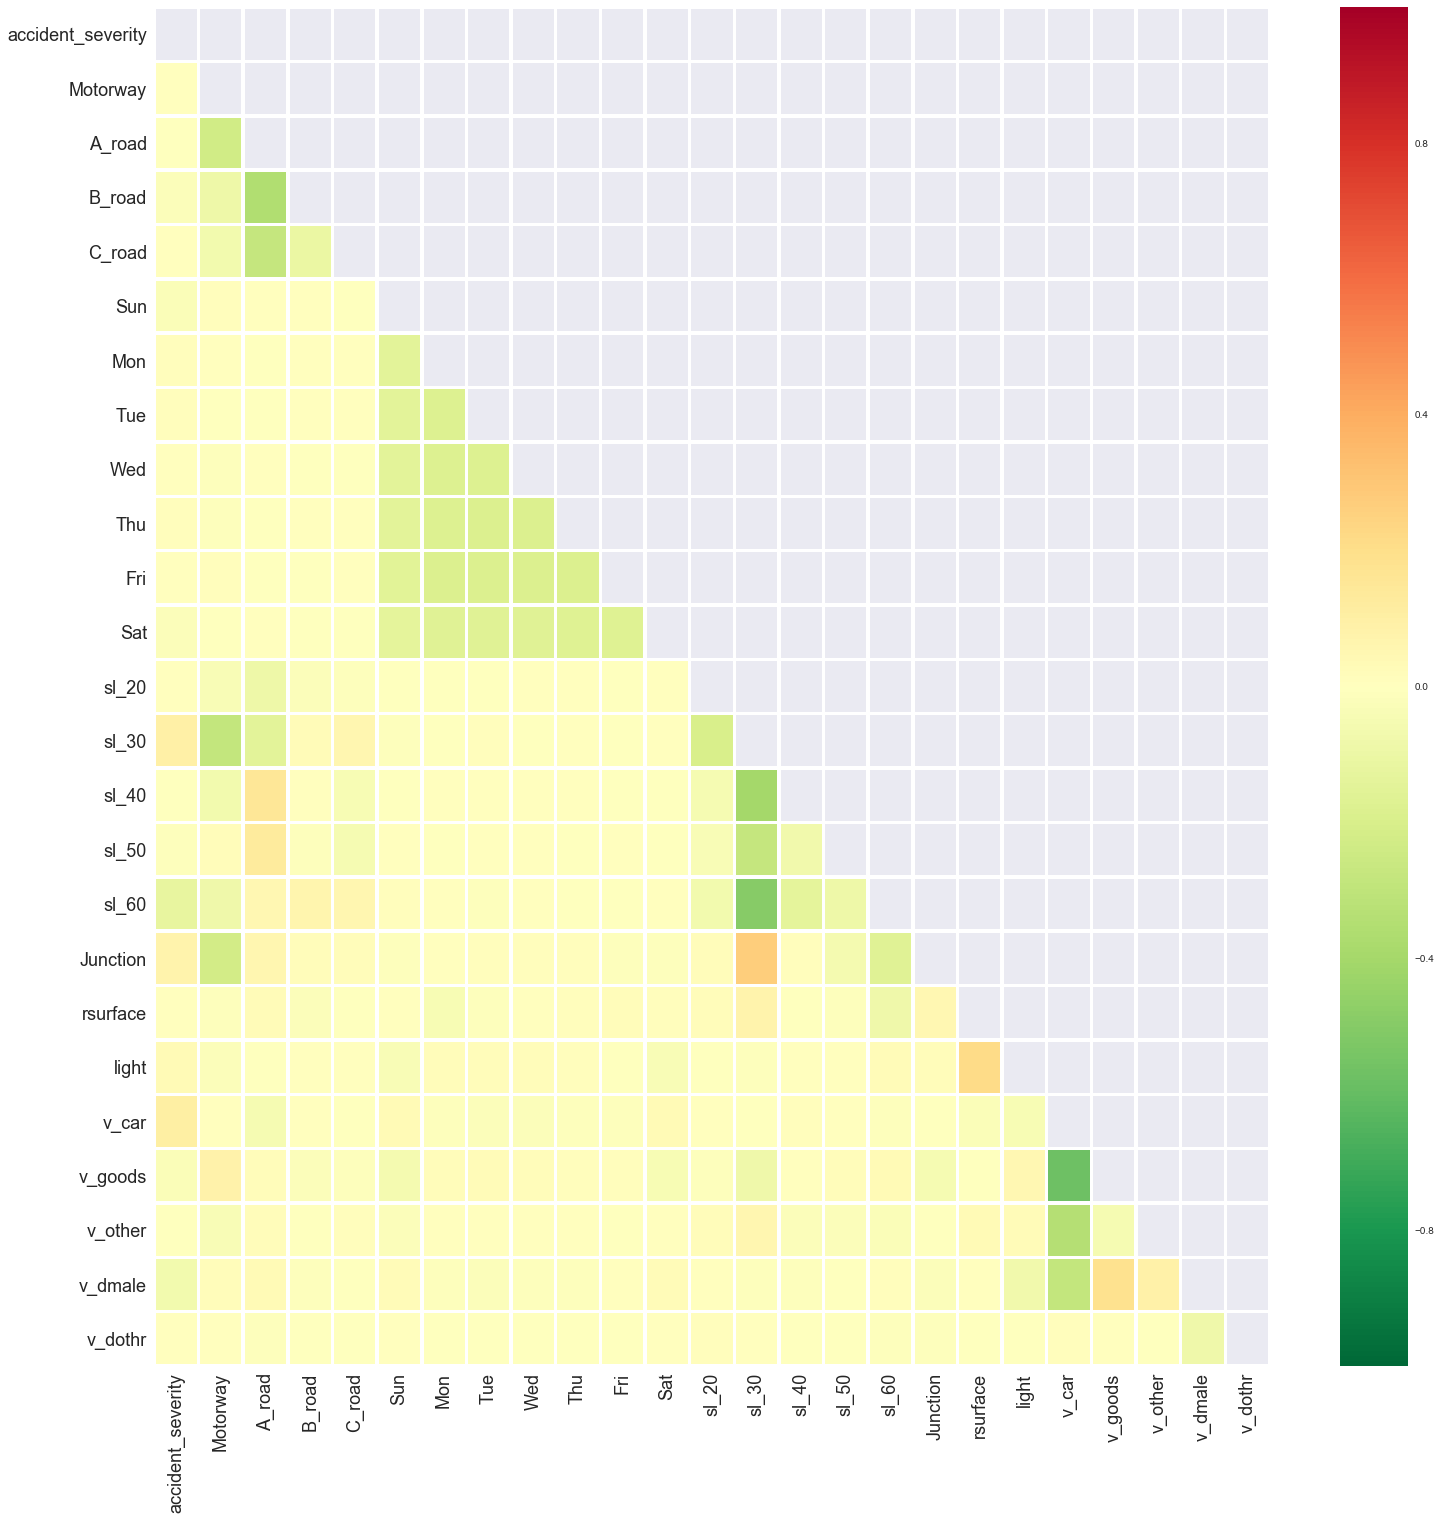

In [16]:
plot_correlation(df_DS, DS_name)